# Term Project - Isolation Forest for Anomaly Detection
> Leigh Goetsch </br>
> CSC 5601 - Theory of Machine Learning </br>
> Milwaukee School of Engineering </br>
> Fall 2025


In [1]:
# imports
from isolation_forest import IsolationForest
import pandas as pd
from scipy import io as sio
import numpy as np
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load and view dataset
Each patient is represented in the data set by six biomechanical attributes derived from the shape and orientation of the pelvis and lumbar spine (in this order): pelvic incidence, pelvic tilt, lumbar lordosis angle, sacral slope, pelvic radius and grade of spondylolisthesis. The following convention is used for the class labels: Normal (NO) and Abnormal (AB).

In [ ]:
# vertebral.mat (MAT-file)
# data_path = '../Data/vertebral.mat'
# data_path = "../Data/satellite.mat"
# data_path = "../Data/satimage-2.mat"
# data_path = "../Data/IRIS.csv"
data_path = "../Data/TUANDROMD.csv"

df_data = pd.read_csv(data_path)


# mat = sio.loadmat(data_path)
# mat.keys()

# X = mat['X']
# y = mat['y'].flatten()
# feature_names = [f"feature_{i}" for i in range(X.shape[1])]
# df_vertebral = pd.DataFrame(X, columns=feature_names)
# df_vertebral["target"] = y
# df_vertebral.describe()


# drop cols with identical values
nunique = df_data.nunique()
cols_to_drop = nunique[nunique == 1].index
df_data = df_data.drop(columns=cols_to_drop)
# drop nulls
df_data = df_data.dropna()

X = df_data.drop(columns=["target"]).values
y = df_data["target"].values

df_data["target"] = np.where(df_data["target"] == 1, 0, 1)  # make anomalies = 1
df_data["target"].value_counts()

# plot ditribution of classes vs features
# sns.pairplot(df_data, hue='target', diag_kind='kde')

target
0    3565
1     899
Name: count, dtype: int64

## Isolation Forest setup

In [12]:
iso_forest = IsolationForest(n_trees=1500, random_state=42, contamination=0.3)
predictions = iso_forest.fit_predict(X)

print(classification_report(y, predictions, target_names=["Inlier", "Outlier"]))

              precision    recall  f1-score   support

      Inlier       0.14      0.57      0.23       899
     Outlier       0.54      0.13      0.21      3565

    accuracy                           0.22      4464
   macro avg       0.34      0.35      0.22      4464
weighted avg       0.46      0.22      0.21      4464



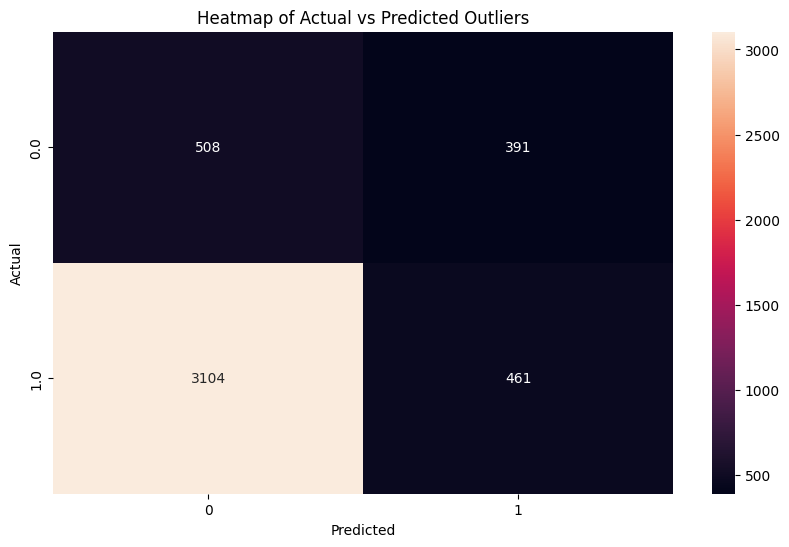

In [13]:
# heatmap visualization of predictions vs actual

plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(y, predictions, rownames=['Actual'], colnames=['Predicted']), annot=True, fmt='d')
plt.title('Heatmap of Actual vs Predicted Outliers')
plt.show()

In [ ]:
# scatter grid of all feature pairs
pd.plotting.scatter_matrix(
    df_vertebral[feature_names],
    c=y,
    figsize=(15, 15),
    marker="o",
    hist_kwds={"bins": 20},
    s=60,
    alpha=0.8,
)
plt.show()

pd.plotting.scatter_matrix(
    df_vertebral[feature_names],
    c=predictions,
    figsize=(15, 15),
    marker="o",
    hist_kwds={"bins": 20},
    s=60,
    alpha=0.8,
)
plt.show()
